# Wrangle and Analyze Data

### Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy
import requests
import tweepy 
import json
import config
import numpy as np

### Import Data

In [8]:
image_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
# Image predictions df info
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- `tweet_id` should be a string.
- `p1`, `p2`, and `p3` the predictions, have dog breed names with underscores.

### WeRateDogs Archive Tweet Archive Data

In [10]:
# Archive data info
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
twitter_archive.text[3] # view the text field

'This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ'

In [12]:
twitter_archive.name = twitter_archive.name.map(lambda x: x.upper())
twitter_archive.name[twitter_archive.name.isin(['THE', 'A', 'AN'])] # find names that are definite articles

56       A
649      A
759     AN
801      A
1002     A
        ..
2349    AN
2350     A
2352     A
2353     A
2354     A
Name: name, Length: 70, dtype: object

- `tweet_id` should be a string. This field does not provide information as a numerical value.
- `timestamp` should be in datetime format instead of string format.
- `name` field includes invalid dog names that are definite articles. 

### Tweet RT Count & Favorite Data

In [13]:
# Tweet rt count and favorite df info
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        877 non-null    int64
 1   retweet_count   877 non-null    int64
 2   favorite_count  877 non-null    int64
dtypes: int64(3)
memory usage: 20.7 KB


- `tweet_id` should be a string.

## Consistency

In [14]:
# Accessing third series element as example
print(twitter_archive.text[3], '\n')
print(twitter_archive.rating_numerator[3], twitter_archive.rating_denominator[3])

This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ 

13 10


- The `text` field contains dog image URLs which do not provide informative textual information. 

## Accuracy

Seeing as the `text` field from the archive data contained the dog ratings, I decided to extract the ratings in this field and compare them to the `rating_numerator` and `rating_denominator` fields to test for accuracy.

In [15]:
# Extract ratings from [text] field in twitter_archive using regex expressions
numerator_test = twitter_archive.text.str.extract(r'([0-9]{1,4})\/', expand=False) # create a series with extracted rating numerator from text
numerator_test = pd.to_numeric(numerator_test, errors='coerce').fillna(0).astype(np.int64)

denominator_test = twitter_archive.text.str.extract(r'\/([0-9]{1,3})', expand=False) # create series with extracted rating denominator from text
denominator_test = pd.to_numeric(denominator_test, errors='coerce').fillna(0).astype(np.int64)

# Create series with rating as decimal
ratings_test_series = pd.Series(numerator_test / denominator_test).replace(np.inf, 0)

The rating numerator and denominators are extracted from the `text` field and saved as separate Series. Then, I create a series that calculates the rating by dividing the extracted numerator by the extracted denominator. Many othe values are greater than 1 because the WeRateDogs page nearly always gives ratings greater than 10/10 because the animals are just so cute that they deserve 12/10--or even greater in some instances!

In [16]:
ratings_test_series.max() # extract max rating

177.6

The greatest rating extracted from the text was 66$ out of 10! Quite the prankster rating.  

In [17]:
print(twitter_archive.text[979])
print(twitter_archive.rating_numerator[979], '/' , twitter_archive.rating_denominator[979])

This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1776 / 10


In [18]:
# Create a series calculating rating as [rating_numerator] / [rating_denominator]
archive_rating = pd.Series(twitter_archive.rating_numerator / twitter_archive.rating_denominator).replace(np.inf, 0)

In [19]:
# Compare numerators
print(archive_rating.compare(ratings_test_series))
print("\nCount --> ", len(archive_rating.compare(ratings_test_series)))

Empty DataFrame
Columns: [self, other]
Index: []

Count -->  0


The dog ratings do appear to be successfully parsed from the tweet text since the comparison yields no differences between the two series. 

# Tidiness Issues

- The retweet and favorite counts are in a separate table than the tweet archive table.
- The `doggo`, `floofer`, `pupper`, and `puppo` fields represent an original ranking that should be one column. 

# Cleaning

### Image Prediction Data

In [20]:
# tweet_id should be a string
image_pred_df['tweet_id'] = image_pred_df['tweet_id'].astype(str)
image_pred_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


The `tweet_id` field is now a string.

In [21]:
# Remove underscores from name and title them
image_pred_df[['p1','p2','p3']] = image_pred_df[['p1','p2','p3']].applymap(lambda x: x.replace("_", " ").title())
image_pred_df[['p1','p2','p3']].loc[:5,:]

,p1,p2,p3
0,Welsh Springer Spaniel,Collie,Shetland Sheepdog
1,Redbone,Miniature Pinscher,Rhodesian Ridgeback
2,German Shepherd,Malinois,Bloodhound
3,Rhodesian Ridgeback,Redbone,Miniature Pinscher
4,Miniature Pinscher,Rottweiler,Doberman
5,Bernese Mountain Dog,English Springer,Greater Swiss Mountain Dog


The predicted breeds are now titled, more visually appealing and easier to use in any visualizations or table operations.

### WeRateDogs Archive

In [22]:
# Remove fields with significant missing data
remove_cols = ["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "expanded_urls"]
twitter_archive = twitter_archive.drop(remove_cols, axis=1)
twitter_archive.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,PHINEAS,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,TILLY,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,ARCHIE,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,DARLA,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,FRANKLIN,None,None,None,None


In [23]:
# Change tweet_id to str
twitter_archive['tweet_id'] = twitter_archive['tweet_id'].astype(str)

In [24]:
# Change timestamp to datetime format
twitter_archive['timestamp'] = pd.to_datetime(twitter_archive['timestamp'])
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   object             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   rating_numerator    2356 non-null   int64              
 5   rating_denominator  2356 non-null   int64              
 6   name                2356 non-null   object             
 7   doggo               2356 non-null   object             
 8   floofer             2356 non-null   object             
 9   pupper              2356 non-null   object             
 10  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(8)
memory usage: 202.6+ KB


In [25]:
# Replace invalid dog names with empty str
twitter_archive['name'] = twitter_archive['name'].replace(to_replace=['THE', 'A', 'AN'], value="")

In [26]:
# Remove URL from text field
twitter_archive['text'] = twitter_archive['text'].str.replace(r'(\bhttps.*)', repl="", regex=True) # remove URLS
twitter_archive['text'] = twitter_archive['text'].str.strip() # strip whitespace
twitter_archive['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10"

The text field is now cleaned of the image URL. 

### RTs and Favorites

In [27]:
# Change tweet_id to string
tweets_df['tweet_id'] = tweets_df['tweet_id'].astype(str)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        877 non-null    object
 1   retweet_count   877 non-null    int64 
 2   favorite_count  877 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 20.7+ KB


## Create Tidy Data

In [33]:
# Join retweet and favorite counts to archive data
# Set tweet_id as index, comment out after
tweets_df.set_index('tweet_id', inplace=True)
twitter_archive.set_index('tweet_id', inplace=True)

In [34]:
# Join the DFs
twitter_archive = twitter_archive.join(tweets_df)

The archive data now includes retweet (RT) counts and favorite counts.

In [36]:
# Merge the "Dogtionary" columns into a new column and drop them
merge_cols = ["doggo", "floofer","pupper","puppo"]
twitter_archive['dogtionary'] = twitter_archive['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [37]:
twitter_archive = twitter_archive.drop(merge_cols, axis=1) 

In [38]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           2356 non-null   datetime64[ns, UTC]
 1   source              2356 non-null   object             
 2   text                2356 non-null   object             
 3   rating_numerator    2356 non-null   int64              
 4   rating_denominator  2356 non-null   int64              
 5   name                2356 non-null   object             
 6   retweet_count       877 non-null    float64            
 7   favorite_count      877 non-null    float64            
 8   dogtionary          399 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(4)
memory usage: 248.6+ KB


In [39]:
twitter_archive[twitter_archive['dogtionary'].notnull()]

,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dogtionary
tweet_id,,,,,,,,,
890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,CASSIE,6428.0,29052.0,doggo
889665388333682689,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,13,10,NONE,8795.0,43747.0,puppo
889531135344209921,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,13,10,STUART,1985.0,13853.0,puppo
886366144734445568,2017-07-15 23:25:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,12,10,ROSCOE,2781.0,19266.0,pupper
884162670584377345,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,12,10,YOGI,2631.0,18613.0,doggo
...,...,...,...,...,...,...,...,...,...
672481316919734272,2015-12-03 18:23:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Jazz. She should be on the cover ...,12,10,JAZZ,NaN,NaN,pupper
672254177670729728,2015-12-03 03:21:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Rolf. He's having the time of his life...,11,10,ROLF,NaN,NaN,pupper
672205392827572224,2015-12-03 00:07:09+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Opal. He's a Royal John Coctostan. Rea...,9,10,OPAL,NaN,NaN,pupper


The "dogtionary" columns are now one column.

## Write Cleaned Data to CSV

The cleaned dataset will be written to a CSV.

In [40]:
twitter_archive.to_csv('twitter_archive_master.csv', encoding='utf-8')

## Visualizing Data

In this section we will visualize the cleaned dataset and examine the following:
1. How did the monthly number of tweets on WeRateDogs change over time?
2. What is the relationship between retweets and favorites?
3. How did retweet and favorite counts vary by dog breed?

In [161]:
# pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [46]:
# import archive master as df
df = pd.read_csv('twitter_archive_master.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2356 entries, 2017-08-01 16:23:56+00:00 to 2015-11-15 22:32:08+00:00
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2356 non-null   int64  
 1   source              2356 non-null   object 
 2   text                2356 non-null   object 
 3   rating_numerator    2356 non-null   int64  
 4   rating_denominator  2356 non-null   int64  
 5   name                2286 non-null   object 
 6   retweet_count       877 non-null    float64
 7   favorite_count      877 non-null    float64
 8   dogtionary          399 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 184.1+ KB


### Tweets Over Time

In [48]:
# Create copy of df
monthly_tweets = df.groupby(pd.Grouper(level='timestamp', freq="M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp','tweet_id']]
monthly_tweets.rename(columns={'tweet_id':'monthly_count'},inplace=True)
monthly_tweets.set_index('timestamp',inplace=True)
monthly_tweets.head()

,monthly_count
timestamp,
2015-11-30 00:00:00+00:00,302
2015-12-31 00:00:00+00:00,388
2016-01-31 00:00:00+00:00,194
2016-02-29 00:00:00+00:00,125
2016-03-31 00:00:00+00:00,137


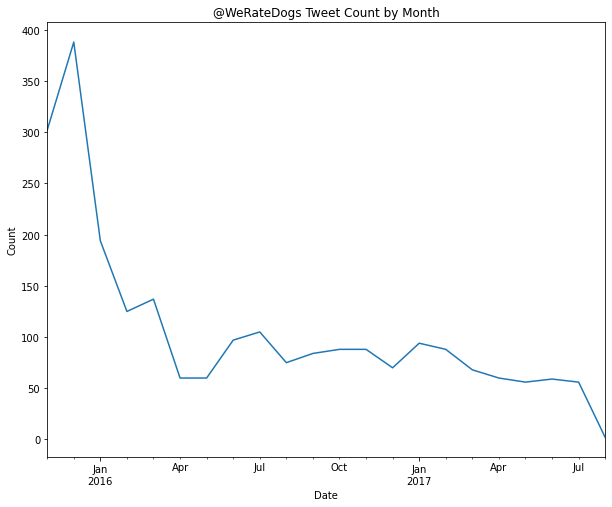

In [49]:
# Plot tweets by month
monthly_tweets.plot(figsize=(10,8), 
                   title='@WeRateDogs Tweet Count by Month',
                   xlabel='Date',
                   ylabel='Count',
                   legend=False);

In [50]:
pct_changes = monthly_tweets.pct_change()
pct_changes.style.format("{:.2%}").highlight_min()

,monthly_count
timestamp,
2015-11-30 00:00:00+00:00,nan%
2015-12-31 00:00:00+00:00,28.48%
2016-01-31 00:00:00+00:00,-50.00%
2016-02-29 00:00:00+00:00,-35.57%
2016-03-31 00:00:00+00:00,9.60%
2016-04-30 00:00:00+00:00,-56.20%
2016-05-31 00:00:00+00:00,0.00%
2016-06-30 00:00:00+00:00,61.67%
2016-07-31 00:00:00+00:00,8.25%


Over the course of the period, the tweet count declined significantly, this will be further examined in the act_report.

### Retweet and Favorites by Dog Name

In [116]:
# Groupby name and select records with RTs and favorite count information
popular_names = df[df[['retweet_count','favorite_count']].isna().any(1) == False] # select records where RTs and favorites not empty
popular_names = popular_names.groupby('name')[['retweet_count','favorite_count']].sum() # group by name
popular_names = popular_names.drop('NONE') # remove records with no dog name
# popular_names.sort_values(['retweet_count','favorite_count'], inplace=True, ascending=False) # sort values
# popular_names = popular_names.iloc[:20,:]
# popular_names

y=0.370242x+-816.319020


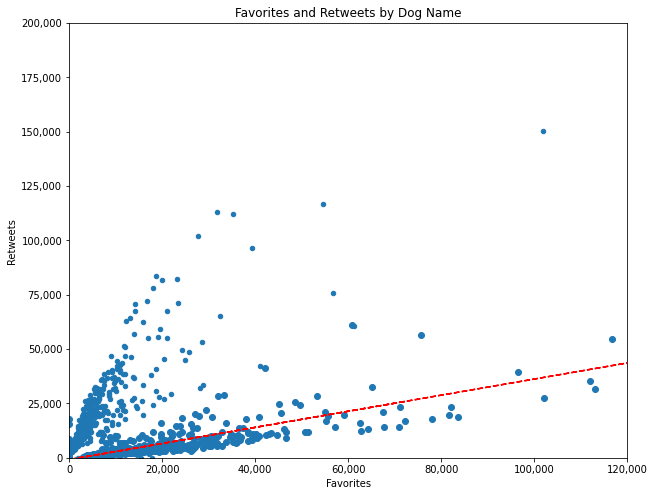

In [129]:
ax = popular_names.plot.scatter(x='retweet_count', 
                                y='favorite_count',
                                title='Favorites and Retweets by Dog Name',
                                xlabel='Favorites',
                                ylabel='Retweets',
                                xlim=(0,120000),
                               ylim=(0,200000),
                               figsize=(10,8))

ax.ticklabel_format(style='plain') # change scientific formatting to plain
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # format y-axis labels
ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # format x-axis labels

RTs = popular_names['retweet_count']
fav = popular_names['favorite_count']
plt.plot(fav,RTs,'o')

# calc the trendline
z = numpy.polyfit(fav, RTs, 1)
p = numpy.poly1d(z)
plt.plot(fav,p(fav),"r--")
# the line equation:
print("y={:.6f}x+{:.6f}".format(z[0],z[1]))

There is a positive relationship between the number of favorites and retweets.

### Retweet and Favorites by Dog Breed